In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
import os
import fnmatch
import csv
import pickle
import warnings
import torch
import time

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

### Create architecture

In [82]:
def make_model(inputs, n_outputs):

    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.leaky_relu)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.sigmoid)
    #hidden_layer_4 = tf.layers.dense(hidden_layer_3, 5, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dropout(hidden_layer_3, 0.05)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [83]:
tf.reset_default_graph()
from copy import copy
from sklearn.model_selection import train_test_split

x = tf.placeholder("float", [None, 3])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

df_train_full_1 = pd.read_csv('Data/Apr/training_merged_3.csv', header=0)

print(min(df_train_full_1['y']))
df_train_pseudo = pd.read_csv('Data/May/pseudo_trainingsdata_x.csv', header=0, names=['x', 'time', 'energy', 'y', 'sigma'])
df_train_full = pd.concat([df_train_full_1, df_train_pseudo], axis=0, ignore_index=True)
print(min(df_train_full['y']))
df_train, df_test = train_test_split(df_train_full, test_size=0.15)
train_x = np.array(df_train[['x', 'time', 'energy']].to_numpy())
N_train = len(train_x[:,0])
train_y = np.copy(df_train['y']).reshape(N_train,1)
train_sigma = np.copy(df_train['sigma']).reshape(N_train,1)

test_x = np.array(df_test[['x', 'time', 'energy']].to_numpy())
N_test = len(test_x[:,0])
test_y = np.copy(df_test['y']).reshape(N_test,1)
test_sigma = np.copy(df_test['sigma']).reshape(N_test,1)


predictions = make_model(x,1)


0.10021014024255616
0.1


## Set a restriction for the minimum relative error

In [84]:
relative_error = np.divide(train_sigma, train_y)
treshold = 0.001
treshold_error_index = np.where(relative_error >= treshold)[0]
train_x, train_y, train_sigma = train_x[treshold_error_index], train_y[treshold_error_index], train_sigma[treshold_error_index]
N_train = len(train_x)

relative_error = np.divide(test_sigma, test_y)
treshold_error_index = np.where(relative_error > treshold)[0]
test_x, test_y, test_sigma = test_x[treshold_error_index], test_y[treshold_error_index], test_sigma[treshold_error_index]
N_test = len(test_x)


## Create MC replicas

In [85]:
### Create array of Nrep training samples
Nrep = 1000
#pbar = tqdm(total=Nrep)
train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
    train_rep = np.random.normal(0, train_sigma)
    test_rep = np.random.normal(0, test_sigma)
    train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
    test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
    i+=1 
train_y_reps[train_y_reps < .1] = .1    
test_y_reps[test_y_reps < .1] = .1
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

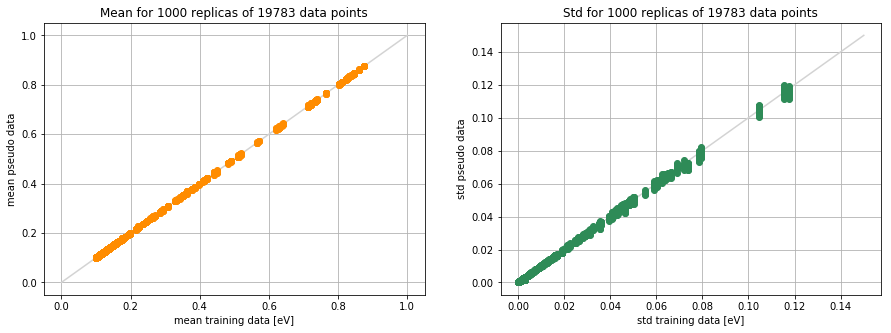

In [86]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Mean for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='lightgrey')
plt.plot(train_y, mean_reps, 'o', color = 'darkorange', label = 'Predictions pseudodata')
plt.grid(True)
plt.xlabel(r'mean training data [eV]')
plt.ylabel(r'mean pseudo data')

plt.subplot(122)
plt.grid(True)
plt.title('Std for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
plt.plot(np.linspace(0,0.15,10), np.linspace(0,0.15,10), color='lightgrey')
plt.plot(train_sigma, std_reps, 'o', color='seagreen', label = 'Predictions pseudodata')
plt.xlabel(r'std training data [eV]')
plt.ylabel(r'std pseudo data')

plt.show()

In [91]:
## Beam energy interpolation

import random
N_pred = 4000
part1 = 1000
interpol_energy1 = 1.5 #*100 keV
interpol_energy2 = 2.5 #*100 keV
interpol_energy3 = 0.5
interpol_energy4 = 2.1
interpol_time = 1

predict_x = np.zeros(shape=(N_pred, 3))
predict_x[:part1,0] = np.linspace(-1,1,part1)
predict_x[part1:2*part1, 0] = np.linspace(-1,1,part1)
predict_x[2*part1:3*part1, 0] = np.linspace(-1,1,part1)
predict_x[3*part1:, 0] = np.linspace(-1,1,part1)
predict_x[:,1] = interpol_time * np.ones(N_pred)
predict_x[:part1,2] = interpol_energy1 * np.ones(part1)
predict_x[part1:2*part1,2] = interpol_energy2 * np.ones(part1)
predict_x[2*part1:3*part1,2] = interpol_energy3 * np.ones(part1)
predict_x[3*part1:,2] = interpol_energy4 * np.ones(part1)
#predict_x[part1:,2] = interpol_energy2 * np.ones(N_pred-part1)

In [92]:
print(predict_x[3200])

[-0.5995996  1.         2.1      ]


In [ ]:
import time
from datetime import datetime

training_epochs = 60000
max_rising_epochs = 10000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 1000
chi_array = []

tic = time.time()

### Define cost and optimizer
cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
eta = 3e-2
optimizer = tf.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(cost)

i = 0
Nrep = 20

while i < (Nrep):
    
    """Training data: train_y = D_i + rand.norm(0, sigma_i);
    use train_y = gaus_y + rand.norm(0, sigma_i) in case of Closure testing"""
    
    train_y = train_y_reps[:,i].reshape(N_train,1)
    test_y = test_y_reps[:,i].reshape(N_test,1)

    ### Train and validate
    prev_test_cost = 100
    prev_epoch=0
    avg_cost = 0.0

    array_train = []
    array_test = []
    
    print("Start training on", '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        

        for epoch in range(training_epochs):

            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: train_x,
                                y: train_y,
                                sigma: train_sigma
                            })
            avg_cost = c 

            test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})


            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                array_train.append(avg_cost)
                array_test.append(test_cost)
            
            if avg_cost < 1.12 and test_cost < 1.2:
                print("Fine outcome")
                break

            if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
                print(colored("\n The session stopped because of overfitting...","red"))
                print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
                break
        
            elif test_cost < prev_test_cost:
                prev_test_cost = test_cost
                prev_epoch = epoch


        print("Optimization Finished!")
        
        predictions_values = sess.run(predictions, 
                            feed_dict={
                                x: train_x,
                                y: train_y 
                            }) 
        
        extrapolation = sess.run(predictions,
                            feed_dict={
                                x: predict_x
                            })
    
    sess.close()

    # save to csv file
    predictions_values = predictions_values.reshape(N_train,)
    toc = time.time()
    print("Elapsed time:", toc-tic)
    
    now = datetime.now()
  
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    d_string = now.strftime("%d.%m.%Y")
    t_string = now.strftime("%H:%M:%S")

    #foot = np.array(seednumber)
    a = np.array(train_x[:,0])
    b = np.array(train_y)
    c = np.array(predictions_values)
    d = array_train
    e = array_test
    g = np.array(train_x[:,1])
    h = np.array(train_x[:,2])
    k1 = np.array(predict_x[:,0])
    k2 = np.array(predict_x[:,1])
    k3 = np.array(predict_x[:,2])
    l = np.array(extrapolation)
    
    chi_array.append(d[-1])

    best_chi = np.where(array_test == min(array_test))
    if test_cost < 1.25: 
        np.savetxt('Data/Results/%(date)s/xyp1p2_all_e%(epoch)s_round4_%(i)s.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(a,b,c,g,h)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
        np.savetxt('Data/Results/%(date)s/chi_all_e%(epoch)s_round4_%(i)s.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(d,e)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
        np.savetxt('Data/Results/%(date)s/extrapolation_e%(epoch)s_round4_%(i)s.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(k1, k2, k3, l)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
 
    print(i)
    i+=1

Start training on 19783 and validating on 3488 samples
Epoch: 0001 | Training cost= 261018.828125000 | Validation cost= 18711.017578125
Epoch: 1001 | Training cost= 16.790102005 | Validation cost= 16.672554016
Epoch: 2001 | Training cost= 16.201328278 | Validation cost= 16.178836823
Epoch: 3001 | Training cost= 16.035516739 | Validation cost= 15.952615738
Epoch: 4001 | Training cost= 15.505017281 | Validation cost= 15.960127831
Epoch: 5001 | Training cost= 16.979764938 | Validation cost= 14.629804611
Epoch: 6001 | Training cost= 13.028829575 | Validation cost= 13.186028481
Epoch: 7001 | Training cost= 11.582848549 | Validation cost= 11.872565269
Epoch: 8001 | Training cost= 11.390522957 | Validation cost= 12.949911118
Epoch: 9001 | Training cost= 7.942801476 | Validation cost= 8.231736183
Epoch: 10001 | Training cost= 5.138885975 | Validation cost= 5.325192928
Epoch: 11001 | Training cost= 2.932266951 | Validation cost= 3.065890551
Epoch: 12001 | Training cost= 2.169789791 | Validation

Epoch: 38001 | Training cost= 43.632381439 | Validation cost= 41.782718658
Epoch: 39001 | Training cost= 1.136712193 | Validation cost= 1.171321034
Epoch: 40001 | Training cost= 1.134101629 | Validation cost= 1.167573452
Epoch: 41001 | Training cost= 2.492412329 | Validation cost= 3.013865232
Epoch: 42001 | Training cost= 1.132189274 | Validation cost= 1.165557861
Epoch: 43001 | Training cost= 7.430997372 | Validation cost= 18.219089508
Epoch: 44001 | Training cost= 1.129499912 | Validation cost= 1.161839485
Epoch: 45001 | Training cost= 1.128301978 | Validation cost= 1.160353303
Epoch: 46001 | Training cost= 1.612225890 | Validation cost= 1.943747997
Epoch: 47001 | Training cost= 1.128523231 | Validation cost= 1.161087751
Epoch: 48001 | Training cost= 1.412320018 | Validation cost= 1.677221537
Epoch: 49001 | Training cost= 1.124619603 | Validation cost= 1.156172395
Epoch: 50001 | Training cost= 1.132046700 | Validation cost= 1.161505580
Epoch: 51001 | Training cost= 1.258917928 | Vali

Epoch: 50001 | Training cost= 2.906118155 | Validation cost= 3.029520512
Epoch: 51001 | Training cost= 3.423209906 | Validation cost= 3.663535118

 The session stopped because of overfitting...
Start overfitting at epoch: 51963 | Validation cost = 40.676086426 | Train cost= 39.128170013
Optimization Finished!
Elapsed time: 1230.138855934143
4
Start training on 19783 and validating on 3488 samples
Epoch: 0001 | Training cost= 1155817.125000000 | Validation cost= 162894.843750000
Epoch: 1001 | Training cost= 17.327501297 | Validation cost= 17.444646835
Epoch: 2001 | Training cost= 16.554721832 | Validation cost= 16.626222610
Epoch: 3001 | Training cost= 15.235516548 | Validation cost= 15.419692993
Epoch: 4001 | Training cost= 15.481692314 | Validation cost= 15.616119385
Epoch: 5001 | Training cost= 14.919289589 | Validation cost= 15.135262489
Epoch: 6001 | Training cost= 14.385115623 | Validation cost= 14.671976089
Epoch: 7001 | Training cost= 14.370191574 | Validation cost= 14.560589790

Epoch: 12001 | Training cost= 6.774536610 | Validation cost= 6.982123852
Epoch: 13001 | Training cost= 3.163652658 | Validation cost= 3.177278042
Epoch: 14001 | Training cost= 2.005777836 | Validation cost= 2.045645714
Epoch: 15001 | Training cost= 5.546122074 | Validation cost= 8.951825142
Epoch: 16001 | Training cost= 1.766316891 | Validation cost= 1.798516750
Epoch: 17001 | Training cost= 1.758013844 | Validation cost= 1.785017014
Epoch: 18001 | Training cost= 10.697327614 | Validation cost= 3.286680937
Epoch: 19001 | Training cost= 1.708601594 | Validation cost= 1.726960778
Epoch: 20001 | Training cost= 1.811833382 | Validation cost= 1.811317921
Epoch: 21001 | Training cost= 1.661926985 | Validation cost= 1.670416713
Epoch: 22001 | Training cost= 1.642877221 | Validation cost= 1.649807692
Epoch: 23001 | Training cost= 1.604316711 | Validation cost= 1.611076713
Epoch: 24001 | Training cost= 1.511906147 | Validation cost= 1.521001697
Epoch: 25001 | Training cost= 1.378805995 | Valida

Epoch: 0001 | Training cost= 134214.906250000 | Validation cost= 23713.724609375
Epoch: 1001 | Training cost= 16.830801010 | Validation cost= 16.971233368
Epoch: 2001 | Training cost= 16.674053192 | Validation cost= 16.834781647
Epoch: 3001 | Training cost= 16.598264694 | Validation cost= 16.751583099
Epoch: 4001 | Training cost= 16.250848770 | Validation cost= 16.385206223
Epoch: 5001 | Training cost= 15.487406731 | Validation cost= 15.634279251
Epoch: 6001 | Training cost= 13.774285316 | Validation cost= 14.007155418
Epoch: 7001 | Training cost= 42.729145050 | Validation cost= 68.664558411
Epoch: 8001 | Training cost= 11.048610687 | Validation cost= 11.517596245
Epoch: 9001 | Training cost= 9.467840195 | Validation cost= 9.946602821
Epoch: 10001 | Training cost= 6.226818562 | Validation cost= 6.608868599
Epoch: 11001 | Training cost= 3.480929136 | Validation cost= 3.586817026
Epoch: 12001 | Training cost= 2.317018270 | Validation cost= 2.411494732
Epoch: 13001 | Training cost= 2.0045

Epoch: 24001 | Training cost= 1.942944407 | Validation cost= 1.869042635
Epoch: 25001 | Training cost= 1.727645159 | Validation cost= 1.778705597
Epoch: 26001 | Training cost= 1.655383587 | Validation cost= 1.691976309
Epoch: 27001 | Training cost= 1.601245046 | Validation cost= 1.633946180
Epoch: 28001 | Training cost= 1.451063514 | Validation cost= 1.466105461
Epoch: 29001 | Training cost= 8.835647583 | Validation cost= 12.748251915
Epoch: 30001 | Training cost= 1.195345044 | Validation cost= 1.208869696
Epoch: 31001 | Training cost= 1.172851443 | Validation cost= 1.157145262
Epoch: 32001 | Training cost= 1.150182843 | Validation cost= 1.152143717
Epoch: 33001 | Training cost= 1.144582391 | Validation cost= 1.138682365
Epoch: 34001 | Training cost= 1.740816116 | Validation cost= 1.498086095
Epoch: 35001 | Training cost= 1.165355802 | Validation cost= 1.139137745
Epoch: 36001 | Training cost= 1.141428113 | Validation cost= 1.131174445
Epoch: 37001 | Training cost= 1.133721709 | Valida

Epoch: 4001 | Training cost= 17.023374557 | Validation cost= 17.202503204
Epoch: 5001 | Training cost= 16.971975327 | Validation cost= 17.157659531
Epoch: 6001 | Training cost= 16.933597565 | Validation cost= 17.105230331
Epoch: 7001 | Training cost= 16.912496567 | Validation cost= 17.083021164
Epoch: 8001 | Training cost= 16.278013229 | Validation cost= 16.436277390
Epoch: 9001 | Training cost= 12.431800842 | Validation cost= 13.057593346
Epoch: 10001 | Training cost= 11.515052795 | Validation cost= 11.982107162
Epoch: 11001 | Training cost= 9.864148140 | Validation cost= 10.334698677
Epoch: 12001 | Training cost= 164.618453979 | Validation cost= 194.902206421
Epoch: 13001 | Training cost= 6.543331623 | Validation cost= 6.962275982
Epoch: 14001 | Training cost= 4.497801781 | Validation cost= 4.759071827
Epoch: 15001 | Training cost= 3.459437132 | Validation cost= 3.668498755
Epoch: 16001 | Training cost= 3.105297565 | Validation cost= 3.288918257
Epoch: 17001 | Training cost= 42.63541

Epoch: 30001 | Training cost= 1.843199849 | Validation cost= 1.914050221
Epoch: 31001 | Training cost= 1.807556152 | Validation cost= 1.872907877
Epoch: 32001 | Training cost= 1.857781529 | Validation cost= 2.172236204
Epoch: 33001 | Training cost= 89.412628174 | Validation cost= 92.074729919
Epoch: 34001 | Training cost= 1.726057410 | Validation cost= 1.783556223
Epoch: 35001 | Training cost= 1.711732507 | Validation cost= 1.766230822
Epoch: 36001 | Training cost= 1.699548244 | Validation cost= 1.752848744
Epoch: 37001 | Training cost= 1.731075168 | Validation cost= 1.845144868
Epoch: 38001 | Training cost= 1.728541732 | Validation cost= 1.757527113
Epoch: 39001 | Training cost= 1.674445868 | Validation cost= 1.729404807
Epoch: 40001 | Training cost= 1.873085141 | Validation cost= 2.305274963
Epoch: 41001 | Training cost= 1.655198216 | Validation cost= 1.705510378
Epoch: 42001 | Training cost= 1.665283918 | Validation cost= 1.712584376
Epoch: 43001 | Training cost= 13.997101784 | Vali

### Plot outputs

In [90]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


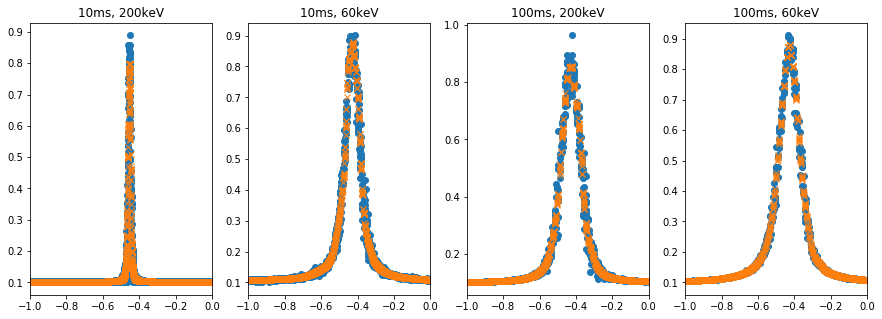

In [38]:
plt.figure(figsize=(15,5))

index10200 = np.where((train_x[:,1] == .1) & (train_x[:,2] == 2))
index1060 = np.where((train_x[:,1] == .1) & (train_x[:,2] == .6))
index100200 = np.where((train_x[:,1] == 1) & (train_x[:,2] == 2))
index10060 = np.where((train_x[:,1] == 1) & (train_x[:,2] == .6))

index10 = np.where(train_x[:,1] == .1)
index100 = np.where(train_x[:,1] == 1)

plt.subplot(141)
plt.title('10ms, 200keV')
plt.xlim([-1,0])
plt.plot(train_x[index10200,0].T, train_y[index10200],'o')
plt.plot(train_x[index10200,0].T, predictions_values[index10200], 'x')
#plt.plot(train_x[index10200,0].T, train_y[index10200],'o')

plt.subplot(142)
plt.xlim([-1,0])
plt.title('10ms, 60keV')
plt.plot(train_x[index1060,0].T, train_y[index1060],'o')
plt.plot(train_x[index1060,0].T, predictions_values[index1060], 'x')

plt.subplot(143)
plt.xlim([-1,0])
plt.title('100ms, 200keV')
plt.plot(train_x[index100200,0].T, train_y[index100200],'o')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x')

plt.subplot(144)
plt.xlim([-1,0])
plt.title('100ms, 60keV')
plt.plot(train_x[index10060,0].T, train_y[index10060],'o')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x')

plt.show()


Below, the distribution of $\chi^2$ is plotted for training over the $N_{rep}$ MC replicas.

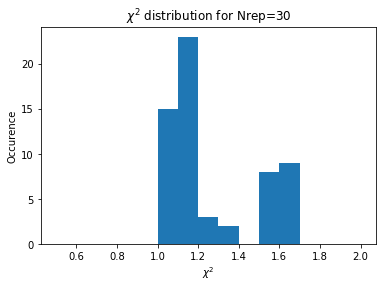

In [162]:
%run Evaluate_pseudodata.ipynb
%run Functions.ipynb
Nrep=30
plt.hist(chi2_array, bins=15, range=[0.5, 2])
plt.title('$\chi^2$ distribution for Nrep=30')
plt.xlabel('$\chi^2$')
plt.ylabel('Occurence')
plt.savefig('Data/Results/%(date)s/aaa chidistribution_%(epoch)s_Nrep=%(i)s' % {"date": d_string, "epoch": training_epochs, "i": Nrep })

plt.show()


## Residuals

In [147]:
N_train = len(train_x[:,0])

best_pred = pseudo_pred[N_train*12 :N_train*13 ]
best_y = pseudo_y[N_train*12 :N_train*13]
train_sigma = train_sigma.reshape(N_train,)

best_res = residuals(best_pred, best_y, train_sigma)

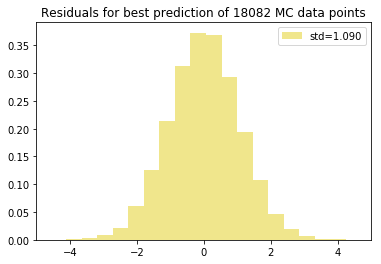

In [148]:
n, bins = np.histogram(best_res, bins=10)

mids = 0.5*(bins[1:] + bins[:-1])
probs = n / np.sum(n)

mean = np.sum(probs * mids)  
sd = np.sqrt(np.sum(probs * (mids - mean)**2))

label1 = 'std=%(std).5s' % {"std":sd}

fig = plt.hist(best_res, bins=20, density=True, color='khaki', label=label1)
plt.title('Residuals for best prediction of %(N_train)s MC data points' % {"N_train": N_train})
plt.legend([label1])

plt.xlim([-5,5])
plt.show()

## Extrapolation in energy loss

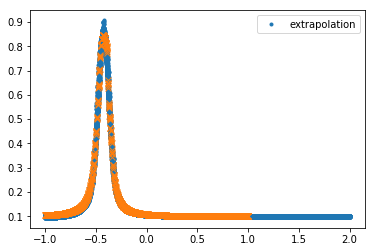

In [224]:
x_extrapol = extrapolation['dE']
prediction = extrapolation['D']
plt.plot(x_extrapol, prediction, '.', label='extrapolation')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x')

plt.legend()


## Interpolation in Beam Energy

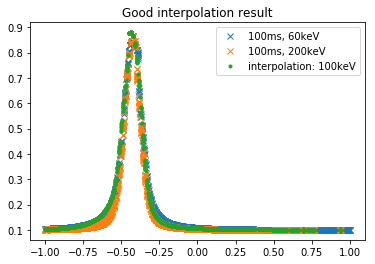

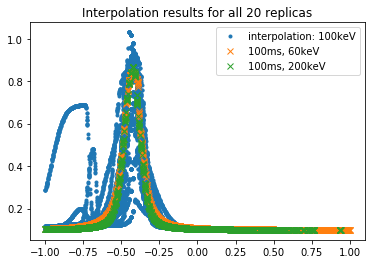

In [230]:
%run Evaluate_pseudodata.ipynb

x_interpol = interpolation['dE']

k=4
prediction_interpol = interpolation['D']
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x', label='100ms, 60keV')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x', label='100ms, 200keV')
plt.plot(x_interpol[k * N_interpol : (k+1)*N_interpol], prediction_interpol[k*N_interpol :(k+1)*N_interpol], '.', label='interpolation: 100keV')
plt.title('Good interpolation result')
plt.legend()
plt.show()

plt.plot(x_interpol, prediction_interpol, '.', label='interpolation: 100keV')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x', label='100ms, 60keV')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x', label='100ms, 200keV')
plt.title('Interpolation results for all 20 replicas')
plt.legend()
plt.show()


## Write everything to report file

In [157]:
import sys
import base64

energy = 200
time = 10
nbins = 60
training_epochs = 100000

reportname = r'Reports/%(date)s_%(energy)skeV_%(time)sms_e%(epoch)s_Nrep=%(i)s.html' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
sys.stdout = open(reportname,'w')


from prettytable import PrettyTable
list1 = ['Energy:','Exposure time:','Nbins:', 'Replicas:', 'Training epochs:']
list2 = [energy, time, nbins, Nrep, training_epochs]

for x in range(0,5):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 



In [ ]:
plot1 = r'Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot2 = r'Data/Results/%(date)s/aaa means-vs-means_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot3 = r'Data/Results/%(date)s/aaa std-vs-std_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot4 = r'Data/Results/%(date)s/aaa Residuals_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }

data_uri1 = base64.b64encode(open(plot1, 'rb').read()).decode('utf-8')
data_uri2 = base64.b64encode(open(plot2, 'rb').read()).decode('utf-8')
data_uri3 = base64.b64encode(open(plot3, 'rb').read()).decode('utf-8')
data_uri4 = base64.b64encode(open(plot4, 'rb').read()).decode('utf-8')
img_tag1 = '<img src="data:image/png;base64,{0}">'.format(data_uri1)
img_tag2 = '<img src="data:image/png;base64,{0}">'.format(data_uri2)
img_tag3 = '<img src="data:image/png;base64,{0}">'.format(data_uri3)
img_tag4 = '<img src="data:image/png;base64,{0}">'.format(data_uri4)

print(img_tag1)
print(img_tag2)
print(img_tag3)
print(img_tag4)